<a href="https://colab.research.google.com/github/abnba24/ma_planning/blob/main/docs/notebooks/10-multiagent-planning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Agent Plan Example

This notebook will show how to generate a plan POP from a multi-agent problem.

[![Open In GitHub](https://img.shields.io/badge/see-Github-579aca?logo=github)](https:///github.com/aiplan4eu/unified-planning/blob/master/docs/notebooks/10-multiagent-planning.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aiplan4eu/unified-planning/blob/master/docs/notebooks/10-multiagent-planning.ipynb)

## Setup the UP library

We start by installing the library with PIP

In [1]:
!apt install graphviz graphviz-dev
%pip install unified-planning[fmap,plot]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


## Demo

In this demo we show how to model a multi-agent planning problem using the Unified Planning library.

Basic imports

In [2]:
from unified_planning.shortcuts import *
from unified_planning.model.multi_agent import *
from collections import namedtuple
from unified_planning.io.ma_pddl_writer import MAPDDLWriter

## Creating the ma-depot problem

We define the UserTypes, the Objects, the Fluents and the Actions

In [3]:
#USERTYPEs
place = UserType("place")
locatable = UserType("locatable")
truck = UserType("truck", locatable)
hoist = UserType("hoist", locatable)
surface = UserType("surface", locatable)
pallet = UserType("pallet", surface)
crate = UserType("crate", surface)
pos = Fluent("pos", place=place)

#FLUENTs
at = Fluent("at", BoolType(), locatable=locatable, place=place)
on = Fluent("on", BoolType(), crate=crate, surface=surface)
In = Fluent("in", BoolType(), crate=crate, truck=truck)
clear = Fluent("clear", BoolType(), surface=surface)

available = Fluent("available", hoist=hoist)
lifting = Fluent("lifting", hoist=hoist, crate=crate)
driving = Fluent("driving", truck=truck)

#OBJECTs
truck0 = Object("truck0", truck)
truck1 = Object("truck1", truck)
depot0_place = Object("depot0_place", place)
distributor0_place = Object("distributor0_place", place)
distributor1_place = Object("distributor1_place", place)
crate0 = Object("crate0", crate)
crate1 = Object("crate1", crate)
pallet0 = Object("pallet0", pallet)
pallet1 = Object("pallet1", pallet)
pallet2 = Object("pallet2", pallet)

hoist0 = Object("hoist0", hoist)
hoist1 = Object("hoist1", hoist)
hoist2 = Object("hoist2", hoist)

#ACTIONs
drive = InstantaneousAction("drive", x=truck, y=place, z=place)
x = drive.parameter("x")
y = drive.parameter("y")
z = drive.parameter("z")

drive.add_precondition(pos(y))
drive.add_precondition(at(x, y))
drive.add_precondition(driving(x))
drive.add_effect(pos(z), True)
drive.add_effect(pos(y), False)
drive.add_effect(at(x, z), True)
drive.add_effect(at(x, y), False)

lift = InstantaneousAction("lift", p=place, x=hoist, y=crate, z=surface)
p = lift.parameter("p")
x = lift.parameter("x")
y = lift.parameter("y")
z = lift.parameter("z")

lift.add_precondition(pos(p))
lift.add_precondition(at(x, p))
lift.add_precondition(available(x))
lift.add_precondition(at(y, p))
lift.add_precondition(on(y, z))
lift.add_precondition(clear(y))

lift.add_effect(lifting(x, y), True)
lift.add_effect(clear(z), True)
lift.add_effect(at(y, p), False)
lift.add_effect(clear(y), False)
lift.add_effect(available(x), False)
lift.add_effect(on(y, z), False)

drop = InstantaneousAction("drop", p=place, x=hoist, y=crate, z=surface)
p = drop.parameter("p")
x = drop.parameter("x")
y = drop.parameter("y")
z = drop.parameter("z")

drop.add_precondition(pos(p))
drop.add_precondition(at(x, p))
drop.add_precondition(at(z, p))
drop.add_precondition(clear(z))
drop.add_precondition(lifting(x, y))

drop.add_effect(available(x), True)
drop.add_effect(at(y, p), True)
drop.add_effect(clear(y), True)
drop.add_effect(on(y, z), True)
drop.add_effect(lifting(x, y), False)
drop.add_effect(clear(z), False)

load = InstantaneousAction("load", p=place, x=hoist, y=crate, z=truck)
p = load.parameter("p")
x = load.parameter("x")
y = load.parameter("y")
z = load.parameter("z")

load.add_precondition(pos(p))
load.add_precondition(at(x, p))
load.add_precondition(at(z, p))
load.add_precondition(lifting(x, y))

load.add_effect(In(y, z), True)
load.add_effect(available(x), True)
load.add_effect(lifting(x, y), False)

unload = InstantaneousAction("unload", p=place, x=hoist, y=crate, z=truck)
p = unload.parameter("p")
x = unload.parameter("x")
y = unload.parameter("y")
z = unload.parameter("z")

unload.add_precondition(pos(p))
unload.add_precondition(at(x, p))
unload.add_precondition(at(z, p))
unload.add_precondition(available(x))
unload.add_precondition(In(y, z))

unload.add_effect(lifting(x, y), True)
unload.add_effect(In(y, z), False)
unload.add_effect(available(x), False)

The class that represents a multi-agent planning problem is unified_planning.MultiAgentProblem, it contains the set of agents, the objects, an intial value for all the fluents and a goal to be reached by the planner. We create a MultiAgentProblem and five Agents. An Agent is an individual entity with specific fluents and specific actions.

In [4]:
problem = MultiAgentProblem("depot")

depot0_a = Agent("depot0_agent", problem)
distributor0_a = Agent("distributor0_agent", problem)
distributor1_a = Agent("distributor1_agent", problem)
driver0_a = Agent("driver0_agent", problem)
driver1_a = Agent("driver1_agent", problem)

We add to the agents the actions they can perform.

In [5]:
driver0_a.add_action(drive)
driver1_a.add_action(drive)

depot0_a.add_action(lift)
depot0_a.add_action(drop)
depot0_a.add_action(load)
depot0_a.add_action(unload)

distributor0_a.add_action(lift)
distributor0_a.add_action(drop)
distributor0_a.add_action(load)
distributor0_a.add_action(unload)

distributor1_a.add_action(lift)
distributor1_a.add_action(drop)
distributor1_a.add_action(load)
distributor1_a.add_action(unload)

Let's add the fluents that aren't owned by the agents to the `ma_environment`.
Note: Environment fluents are associated to environment’s and not agents’ properties.

In [6]:
problem.ma_environment.add_fluent(at, default_initial_value=False)
problem.ma_environment.add_fluent(on, default_initial_value=False)
problem.ma_environment.add_fluent(In, default_initial_value=False)
problem.ma_environment.add_fluent(clear, default_initial_value=False)

bool clear[surface=surface - locatable]

Let's add the `Fluents` to the `Agents`. Note: An agent's fluent can be of two types, public or private. `Public Fluents` are visible to other agents. In contrast, the `Private Fluents` are not visible from the other agents.
Private fluents are added to the agent via the `add_fluent` or `add_private_fluent` methods and public fluents via the `add_public_fluent` method.

In [7]:
depot0_a.add_private_fluent(lifting, default_initial_value=False)
depot0_a.add_private_fluent(available, default_initial_value=False)

distributor0_a.add_private_fluent(lifting, default_initial_value=False)
distributor0_a.add_private_fluent(available, default_initial_value=False)

distributor1_a.add_private_fluent(lifting, default_initial_value=False)
distributor1_a.add_private_fluent(available, default_initial_value=False)

driver0_a.add_private_fluent(driving, default_initial_value=False)
driver1_a.add_private_fluent(driving, default_initial_value=False)

depot0_a.add_public_fluent(pos, default_initial_value=False)
distributor0_a.add_public_fluent(pos, default_initial_value=False)
distributor1_a.add_public_fluent(pos, default_initial_value=False)
driver0_a.add_public_fluent(pos, default_initial_value=False)
driver1_a.add_public_fluent(pos, default_initial_value=False)

bool pos[place=place]

Let's add the agents to the `MultiAgentProblem`.

In [8]:
problem.add_agent(depot0_a)
problem.add_agent(distributor0_a)
problem.add_agent(distributor1_a)
problem.add_agent(driver0_a)
problem.add_agent(driver1_a)

We add the objects, the initial values and the goals.
Note: `Dot` operator is used to denote agent-specific `Fluents`.

In [9]:
#OBJECTs
problem.add_object(crate0)
problem.add_object(crate1)
problem.add_object(truck0)
problem.add_object(truck1)
problem.add_object(depot0_place)
problem.add_object(distributor0_place)
problem.add_object(distributor1_place)
problem.add_object(pallet0)
problem.add_object(pallet1)
problem.add_object(pallet2)
problem.add_object(hoist0)
problem.add_object(hoist1)
problem.add_object(hoist2)

#INITIAL VALUEs
problem.set_initial_value(at(pallet0, depot0_place), True)
problem.set_initial_value(clear(crate1), True)
problem.set_initial_value(at(pallet1, distributor0_place), True)
problem.set_initial_value(clear(crate0), True)
problem.set_initial_value(at(pallet2, distributor1_place), True)
problem.set_initial_value(clear(pallet2), True)

problem.set_initial_value(at(truck0, distributor1_place), True)
problem.set_initial_value(at(truck1, depot0_place), True)
problem.set_initial_value(at(hoist0, depot0_place), True)
problem.set_initial_value(at(hoist1, distributor0_place), True)
problem.set_initial_value(at(hoist2, distributor1_place), True)
problem.set_initial_value(at(crate0, distributor0_place), True)
problem.set_initial_value(on(crate0, pallet1), True)
problem.set_initial_value(at(crate1, depot0_place), True)
problem.set_initial_value(on(crate1, pallet0), True)

problem.set_initial_value(
    Dot(driver0_a, pos(distributor1_place)), True
)
problem.set_initial_value(Dot(driver1_a, pos(depot0_place)), True)
problem.set_initial_value(Dot(depot0_a, pos(depot0_place)), True)
problem.set_initial_value(Dot(depot0_a, available(hoist0)), True)
problem.set_initial_value(Dot(distributor0_a, available(hoist1)), True)
problem.set_initial_value(Dot(distributor1_a, available(hoist2)), True)

problem.set_initial_value(Dot(distributor0_a, pos(distributor0_place)), True)
problem.set_initial_value(Dot(distributor1_a, pos(distributor1_place)), True)

problem.set_initial_value(Dot(driver0_a, driving(truck0)), True)
problem.set_initial_value(Dot(driver1_a, driving(truck1)), True)

#GOALs
problem.add_goal(on(crate0, pallet2))
problem.add_goal(on(crate1, pallet1))

Depot domain explained: https://www.jair.org/index.php/jair/article/view/10351/24754

Derek Long and Maria Fox. 2003. The 3rd International Planning Competition:
Results and Analysis. J. Artif. Intell. Res. (JAIR) 20 (12 2003).

## Solving Multi-Agent Planning Problems

The most direct way to solve a planning problem is to select an available planning engine by name and use it to solve the problem. In the following we use fmap to solve the problem and print the plan.

In [10]:
with OneshotPlanner(problem_kind=problem.kind) as planner:
    result = planner.solve(problem)
    plan = result.plan
    if plan is not None:
        print("FMAP returned: %s" % result.plan)
    else:
        print("No plan found.")

NOTE: To disable printing of planning engine credits, add this line to your code: `up.shortcuts.get_environment().credits_stream = None`
  *** Credits ***
  * In operation mode `OneshotPlanner` at line 1 of `<ipython-input-10-979ddb3cb595>`, you are using the following planning engine:
  * Engine name: FMAP
  * Developers:  Alejandro Torreño, Oscar Sapena and Eva Onaindia
  * Description: FMAP: A Platform for the Development of Distributed Multi-Agent Planning Systems.

FMAP returned: PartialOrderPlan:
  actions:
    0) depot0_agent.lift(depot0_place, hoist0, crate1, pallet0)
    1) distributor0_agent.lift(distributor0_place, hoist1, crate0, pallet1)
    2) depot0_agent.load(depot0_place, hoist0, crate1, truck1)
    3) driver1_agent.drive(truck1, depot0_place, distributor0_place)
    4) distributor0_agent.load(distributor0_place, hoist1, crate0, truck1)
    5) distributor0_agent.unload(distributor0_place, hoist1, crate1, truck1)
    6) distributor0_agent.drop(distributor0_place, hoist1

The unified_planning can also automatically select, among the available planners installed on the system, one that is expressive enough for the problem at hand.

The `all_sequential_plans()` method returns all possible `SequentialPlans` that respects the sorting constraints given by this `PartialOrderPlan`

We can also show all the possible `sequential plans` of this problem.

In [11]:
with OneshotPlanner(problem_kind=problem.kind) as planner:
    result = planner.solve(problem)
    print("All the possible feasible Sequential Plans are:")
    for idx, seq_plan in enumerate(result.plan.all_sequential_plans()):
        print(f"\n{idx}) {seq_plan}")

  *** Credits ***
  * In operation mode `OneshotPlanner` at line 1 of `<ipython-input-11-81d9b2ef5224>`, you are using the following planning engine:
  * Engine name: FMAP
  * Developers:  Alejandro Torreño, Oscar Sapena and Eva Onaindia
  * Description: FMAP: A Platform for the Development of Distributed Multi-Agent Planning Systems.

All the possible feasible Sequential Plans are:

0) SequentialPlan:
    distributor0_agent.lift(distributor0_place, hoist1, crate0, pallet1)
    depot0_agent.lift(depot0_place, hoist0, crate1, pallet0)
    depot0_agent.load(depot0_place, hoist0, crate1, truck1)
    driver1_agent.drive(truck1, depot0_place, distributor0_place)
    distributor0_agent.load(distributor0_place, hoist1, crate0, truck1)
    distributor0_agent.unload(distributor0_place, hoist1, crate1, truck1)
    driver1_agent.drive(truck1, distributor0_place, distributor1_place)
    distributor0_agent.drop(distributor0_place, hoist1, crate1, pallet1)
    distributor1_agent.unload(distributor1_

### Plot the PartialOrderPlan as a graph

We simply use the plot package.

In [12]:
from unified_planning.plot import plot_partial_order_plan

Ignore the code below, it's used to make this notebook also runnable in the Countinuous Intergation.

In [13]:
# Redefine the plot package methods imported above to print the plot to a temp file
# if the exception "could not locate runnable browser" is raised. This usually happens
# in the Continuous Integration.

from inspect import getmembers, isfunction
from unified_planning import plot
from functools import partial
import os, uuid, tempfile as tf

# Define the function that will be executed instead
def _function(original_function, *args, **kwargs):
    try:
        original_function(*args, **kwargs)
    except Exception as e:
        if "could not locate runnable browser" in str(e):
            original_function(*args, **kwargs,
                filename=f"{os.path.join(tf.gettempdir(), str(uuid.uuid1()))}.png"
            )
        else:
            raise e

# Iterate over all the functions of the plot package
for function_name, function in getmembers(plot, isfunction):
    # Override the original function with the new one
    globals()[function_name] = partial(_function, function)

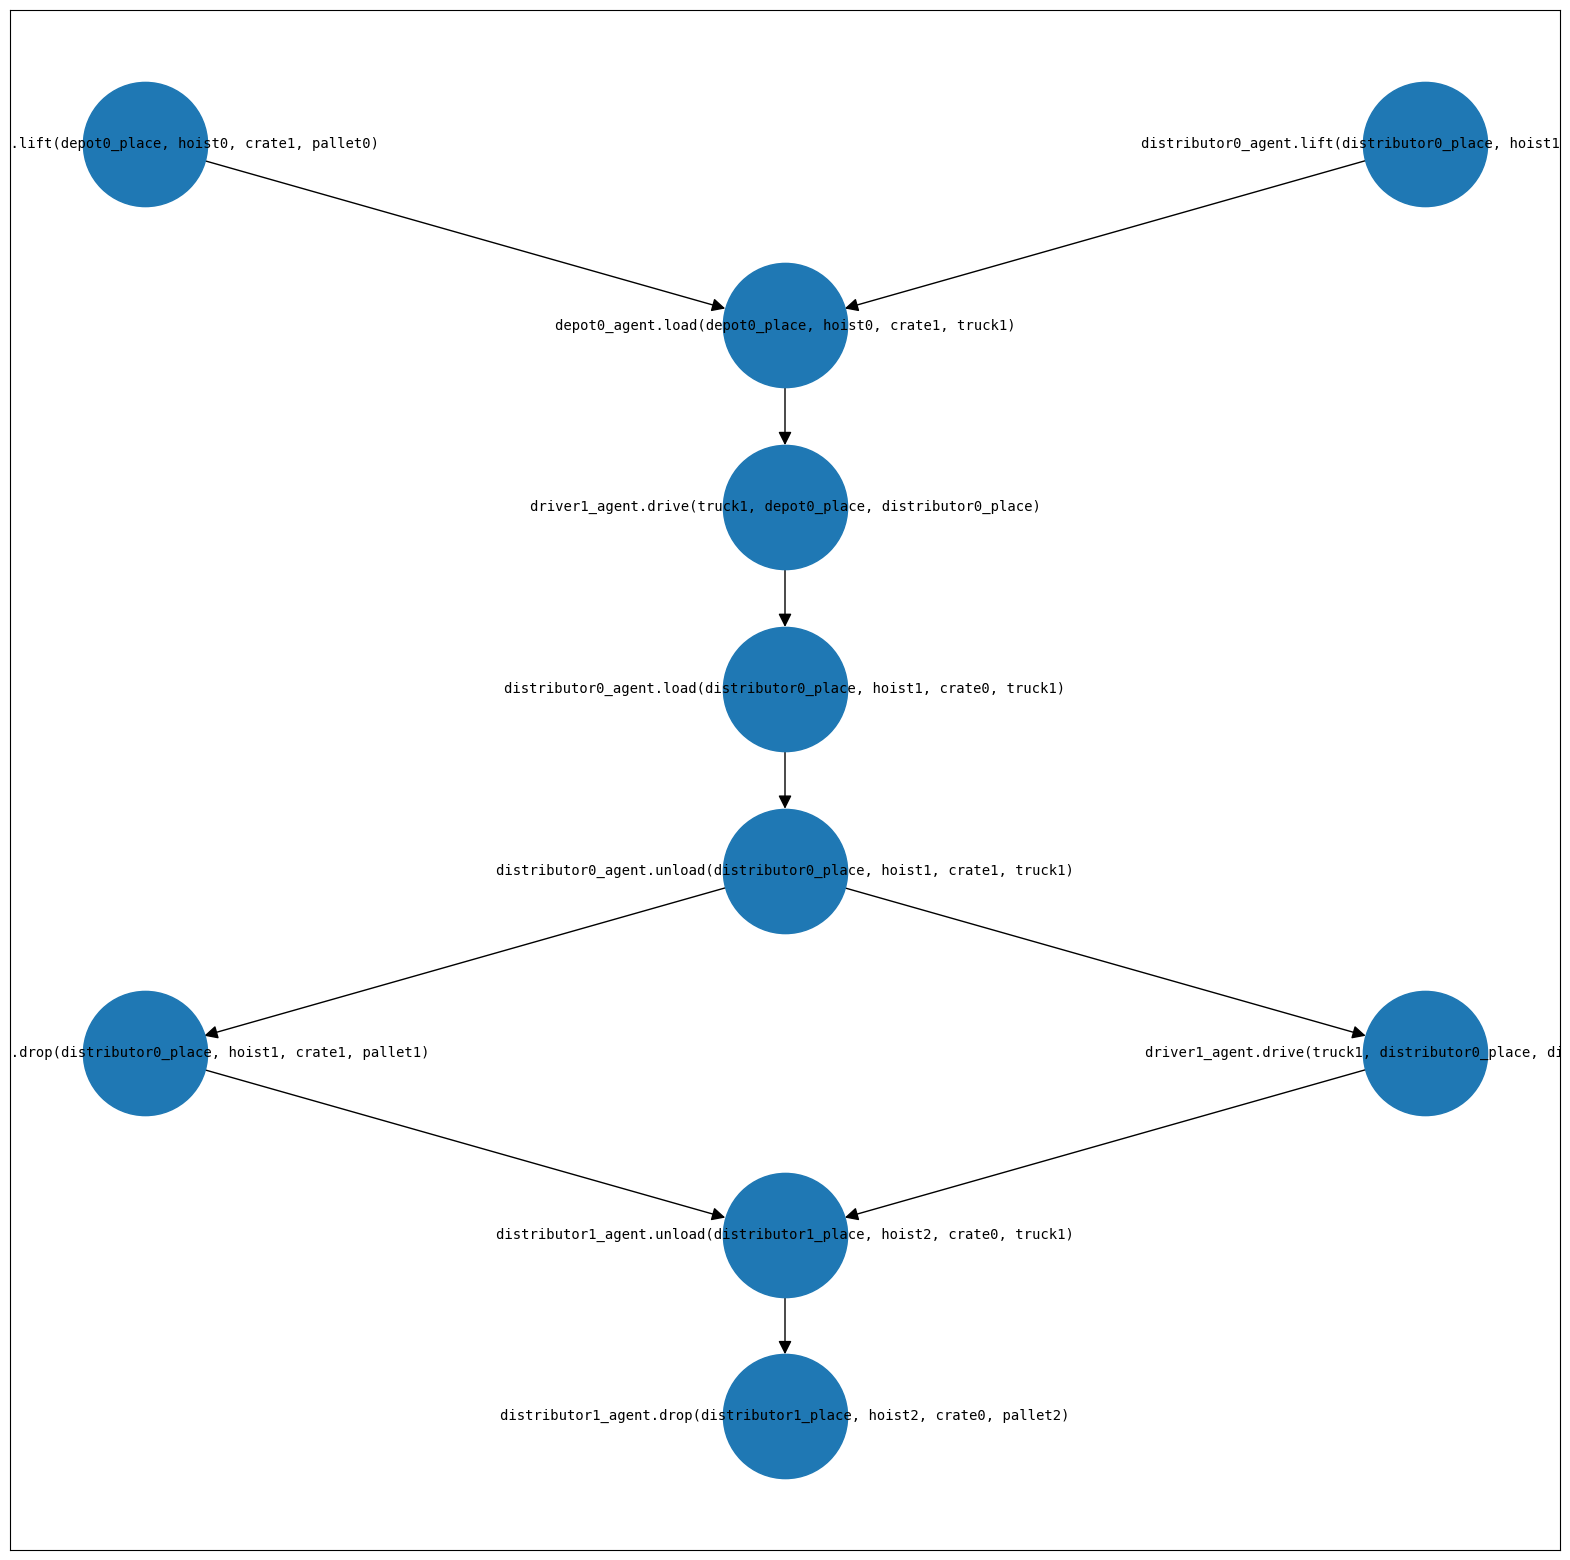

In [14]:
plot_partial_order_plan(result.plan, figsize=(20, 20), node_size=8000, font_size=10, top_bottom=True)